<a href="https://colab.research.google.com/github/gabrielbaltazarmw2/CAMUS-dataset/blob/main/LadderNet_CAMUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das bibliotecas

In [ ]:
# Standard
import os
import sys
import datetime
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow.keras.backend as K
from tensorflow import argmax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

# Utils
import h5py

##Importando o dataset

In [ ]:
from google.colab import drive

# Monta o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Caminho do arquivo original no Google Drive
caminho_original = '/content/drive/MyDrive/Colab Notebooks/CAMUS DATASET/image_dataset.hdf5'

#Preprocessamento

In [ ]:
f = h5py.File(caminho_original, "r")

In [ ]:
frames2ch = f["train 2ch frames"][:,:,:,:]
masks2ch = f["train 2ch masks"][:,:,:,:]

In [ ]:
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ch, masks2ch)

In [ ]:
test_frames.shape

(225, 384, 384, 1)

#Métricas

In [ ]:
def multiclass_dice(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_lv(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:2])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:2])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_la(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,3:4])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,3:4])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_myo(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,2:3])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,2:3])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

#Função de Perda

In [ ]:
def generalized_dice_loss(y_true, y_pred, smooth=1e-7, num_classes=4):

    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return 1.0-K.mean((2. * intersect / (denom + smooth)))

#Implementação LadderNet

In [ ]:
# Implementation of LadderNet using the tf.keras Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

drop = 0.25

def ResBlock(input_tensor, filters):
    """"
    Define Residual Block showed in Zhuang (2019)
    CONV => BATCH => RELU => DROPOUT => CONV => BATCH
      |                                   |
      |----------- SHARED LAYER ----------|

    """

    conv_1 = Conv2D(filters = filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')
    conv_1a = conv_1(input_tensor) # Shared weights conv layer
    batch_1 = BatchNormalization()(conv_1a)
    relu_1  = Activation("relu")(batch_1)
    drop_1  = Dropout(drop)(relu_1)
    conv_1b = conv_1(drop_1) # Shared weights conv layer
    batch_1 = BatchNormalization()(conv_1b)
    return batch_1

def LadderNet(input_size = (256, 256, 1), num_classes=2, filters=30):

    """
    LadderNet (Zhuang, 2019) implementation in tensorflow.keras
    Method: Keras Functional API
    """

    # X's denote standard flow
    # XNUM denote ResBlock outputs

    # "First" UNet

    # Input branch
    inputs = Input(input_size)
    X = Conv2D(filters=filters, kernel_size=3, activation="relu", padding = 'same', kernel_initializer = 'he_normal')(inputs)

    # Down branch
    X1 = ResBlock(input_tensor=X, filters=filters) # ResBlock located in the first layer of the paper scheme
    X = Conv2D(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X1)
    X = Activation("relu")(X) # This ReLU is not shown in the paper scheme

    X2 = ResBlock(input_tensor=X, filters=filters*2)
    X = Conv2D(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X2)
    X = Activation("relu")(X)

    X3 = ResBlock(input_tensor=X, filters=filters*4)
    X = Conv2D(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X3)
    X = Activation("relu")(X)

    X4 = ResBlock(input_tensor=X, filters=filters*8)
    X = Conv2D(filters=filters*16, kernel_size=3, strides=2, kernel_initializer='he_normal')(X4)
    X = Activation("relu")(X)

    # Bottom block
    X = ResBlock(input_tensor=X, filters=filters*16)

    # Up branch
    X = Conv2DTranspose(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X4])
    # X = Activation("relu")(X) # This ReLU is commented in the paper code
    X5 = ResBlock(input_tensor=X, filters=filters*8)

    X = Conv2DTranspose(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X5)
    X = Add()([X, X3])
    # X = Activation("relu")(X)
    X6 = ResBlock(input_tensor=X, filters=filters*4)

    X = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X6)
    X = Add()([X, X2])
    # X = Activation("relu")(X)
    X7 = ResBlock(input_tensor=X, filters=filters*2)

    X = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, output_padding=1, kernel_initializer='he_normal')(X7)
    X = Add()([X, X1])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters)

    # Top block (bottle-neck)
    X8 = ResBlock(input_tensor=X, filters=filters)
    X = ResBlock(input_tensor=X, filters=filters)
    X = Add()([X, X8])

    # "Second" UNet

    # Down branch
    X9 = ResBlock(input_tensor=X, filters=filters)
    X = Conv2D(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X7, X])

    X10 = ResBlock(input_tensor=X, filters=filters*2)
    X = Conv2D(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X6, X])

    X11 = ResBlock(input_tensor=X, filters=filters*4)
    X = Conv2D(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X5, X])

    X12 = ResBlock(input_tensor=X, filters=filters*8)
    X = Conv2D(filters=filters*16, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)

    # Bottom block
    X = ResBlock(input_tensor=X, filters=filters*16)

    # Up branch
    X = Conv2DTranspose(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X12])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*8)

    X = Conv2DTranspose(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X11])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*4)

    X = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X10])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*2)

    X = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, kernel_initializer='he_normal', output_padding=1)(X)
    X = Add()([X, X9])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters)

    # Final block
    X = Conv2D(filters=num_classes, kernel_size=1, kernel_initializer='he_normal')(X)
    # X = Activation("relu")(X)
    X = Activation("softmax")(X)
    #X = Conv2D(1, 1)(X)

    model = Model(inputs, X)


    return model


In [ ]:
model_laddernet = LadderNet(input_size=(384, 384, 1), num_classes=4, filters=20)

earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)
model_laddernet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 20  200         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 384, 384, 20  3620        ['conv2d[0][0]',                 
                                )                                 'dropout[0][0]']            

In [ ]:
model_laddernet.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

In [ ]:
history = model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=50,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/50
135/135 [==============================] - 147s 767ms/step - loss: 0.6890 - multiclass_dice: 0.4928 - accuracy: 0.7791 - val_loss: 298.4214 - val_multiclass_dice: 0.1899 - val_accuracy: 0.1687 - lr: 0.0010
Epoch 2/50
135/135 [==============================] - 103s 763ms/step - loss: 0.2829 - multiclass_dice: 0.7209 - accuracy: 0.9005 - val_loss: 2.8144 - val_multiclass_dice: 0.4453 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 3/50
135/135 [==============================] - 98s 729ms/step - loss: 0.2268 - multiclass_dice: 0.7699 - accuracy: 0.9168 - val_loss: 1.2885 - val_multiclass_dice: 0.5191 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 4/50
135/135 [==============================] - 106s 790ms/step - loss: 0.2013 - multiclass_dice: 0.7935 - accuracy: 0.9248 - val_loss: 0.2662 - val_multiclass_dice: 0.7884 - val_accuracy: 0.9142 - lr: 0.0010
Epoch 5/50
135/135 [==============================] - 99s 736ms/step - loss: 0.1766 - multiclass_dice: 0.8145 - accuracy: 0.9325 - val_loss

In [ ]:
model_laddernet.save('/content/drive/MyDrive/Colab Notebooks/CAMUS DATASET/model_laddernet.h5')
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


#Carregando o modelo

In [ ]:
from tensorflow.keras.models import load_model

# Caminho para o modelo no Google Drive
caminho_modelo = '/content/model_laddernet.h5'

# Carregar o modelo
model_laddernet = load_model(caminho_modelo)

NameError: ignored

#Predição

1/1 [==============================] - 0s 25ms/step


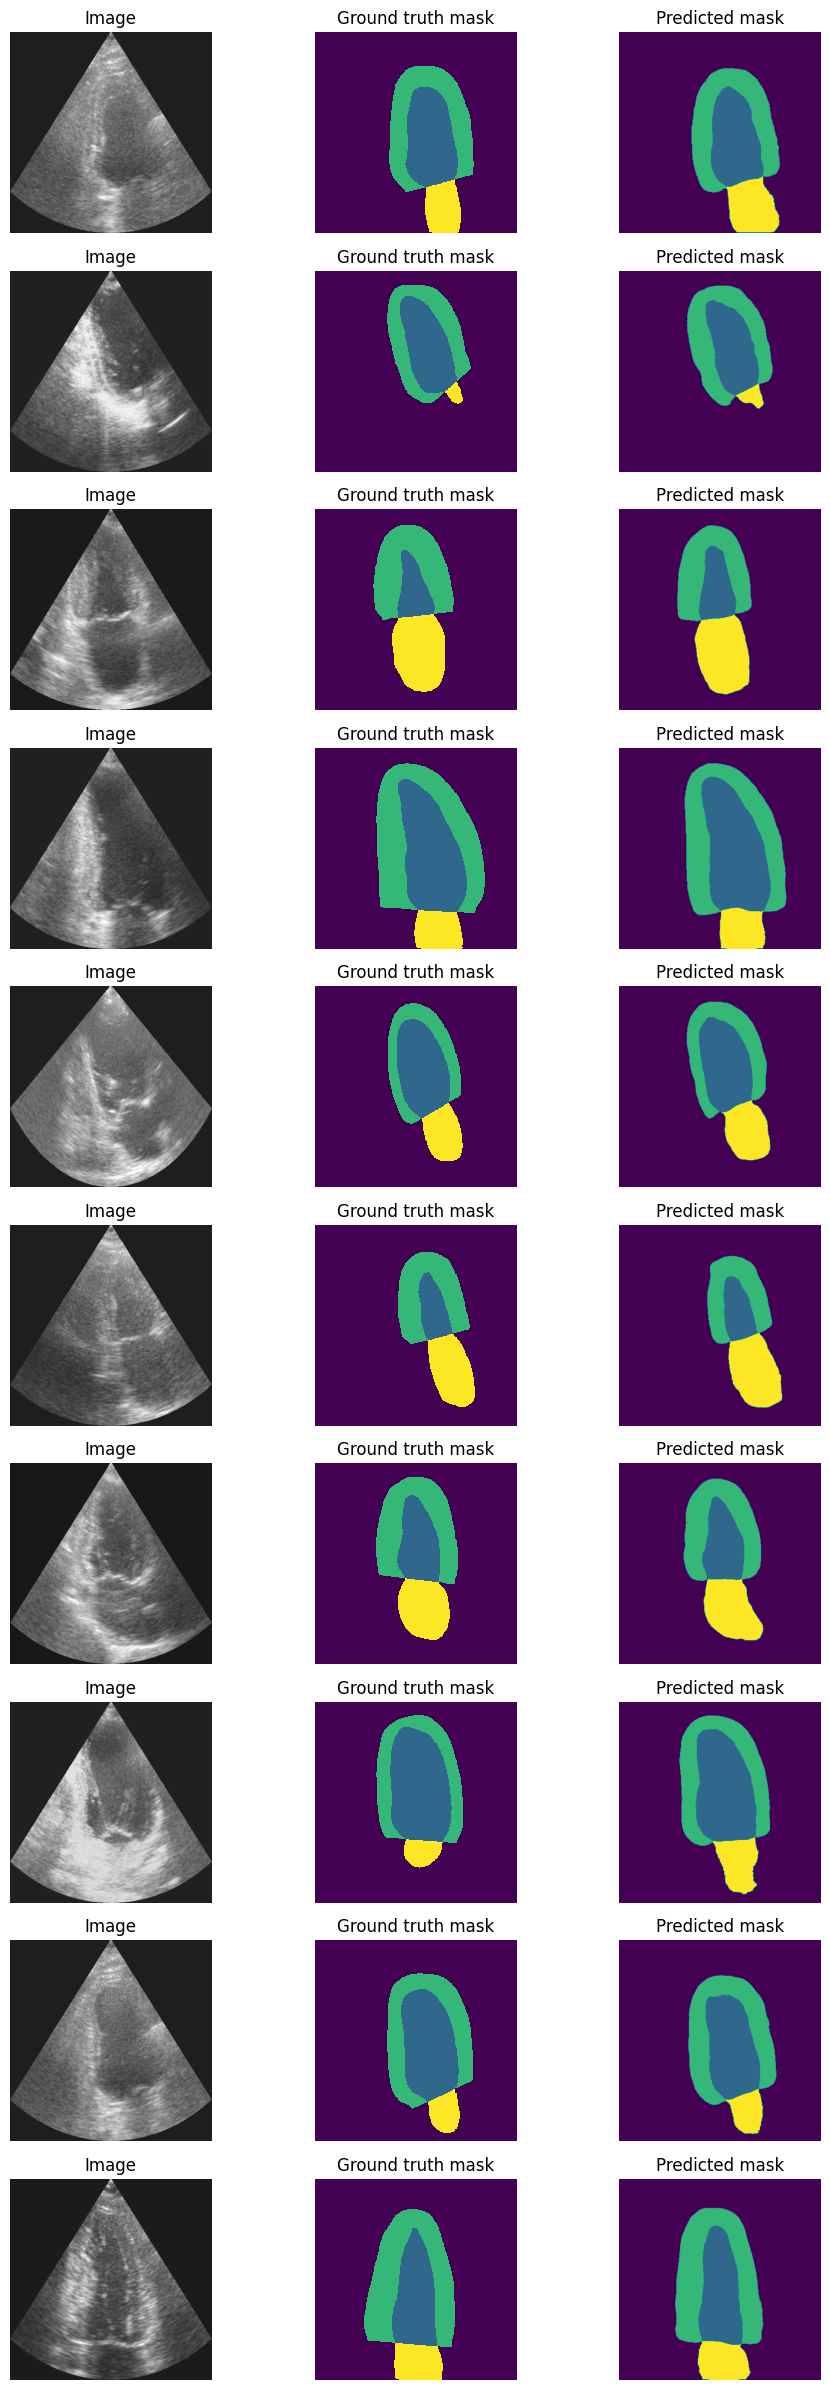

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 10
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i in range(10):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()


predicted_masks = []
for i in range(10):
    prediction = model_laddernet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

In [ ]:
predicted_masks = np.array(predicted_masks)
predicted_masks.shape

(10, 384, 384)

In [ ]:
pip install celluloid

In [ ]:
from celluloid import Camera
from IPython.display import HTML

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(len(predicted_masks)):
    plt.imshow(test_frames[i,:,:], cmap="gray")
    plt.imshow(predicted_masks[i,:,:], alpha=0.3)
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation




In [ ]:
HTML(animation.to_html5_video())  # convert the animation to a video


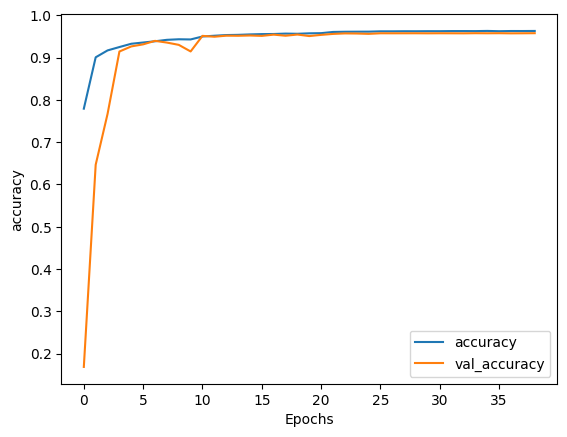

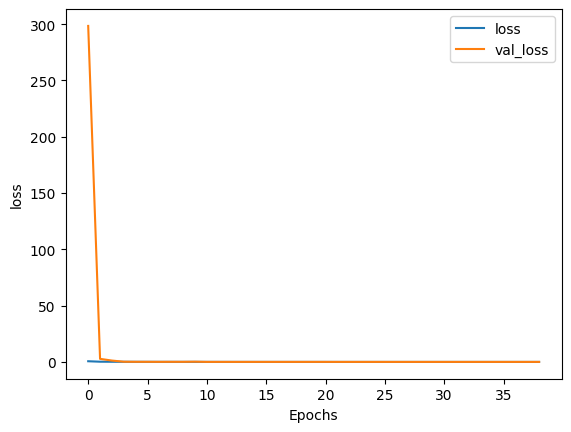

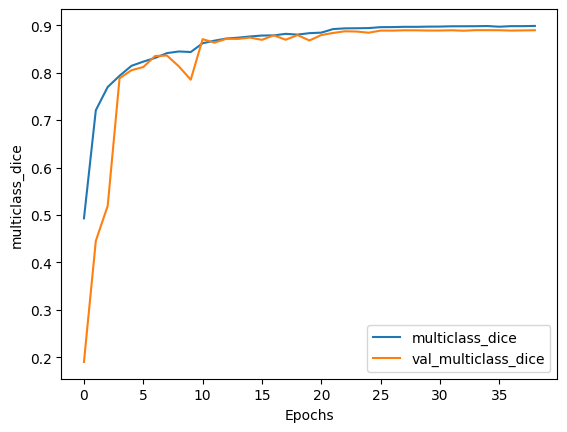

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "multiclass_dice")